In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from post_process_numpy import pol2cord, distance
import matplotlib.image as image
from tqdm import tqdm

In [17]:
cls = np.load(r'dats\data_base_2m.npy',allow_pickle=True).item()

In [ ]:
ad_map = np.load('2019-09-16-13-13-01_000040.npy')
ad_map[31:34,:]=0
ad_map =np.flip(ad_map,axis=1)

In [ ]:
plt.imshow(ad_map)

In [12]:
destination = r'G:\EFS-GX6\4130_Arbeitsgruppen\4137_KHO_Performance\Studentische_Themen\RaviKothari\thesis\images'


In [ ]:
grd_cord = analysis.item()['grd'].to(device='cpu').numpy()
grd_cord = np.reshape(grd_cord,(len(grd_cord)//5,5)).astype('int')
prd_cord = analysis.item()['prd'].to(device='cpu').numpy()
prd_cord = np.reshape(prd_cord,(len(prd_cord)//5,5)).astype('int')

In [ ]:
cord_dict = dict()
for i in range(64):
    cord_dict[f"{i}"]={}
    for j in range(16):
        cord_dict[f"{i}"][f"{j}"]={}
        cord_dict[f"{i}"][f"{j}"]['grd']=[]
        cord_dict[f"{i}"][f"{j}"]['prd']=[]



In [ ]:
for p_cord in prd_cord:
    batch = p_cord[-1]
    frame = p_cord[0]
    cord = p_cord[1:4]
    cord_dict[f"{batch}"][f"{frame}"]['prd'].append(cord)

for g_cord in grd_cord:
    batch = g_cord[-1]
    frame = g_cord[0]
    cord = g_cord[1:4]
    cord_dict[f"{batch}"][f"{frame}"]['grd'].append(cord)


In [ ]:
color = ['blue','green','red']
dir_path = r'/home/ravikothari/dev/analysis'
for i in tqdm(range(64)):
    for j in range(16):
        prd_ind = cord_dict[f"{i}"][f"{j}"]['prd']
        grd_ind = cord_dict[f"{i}"][f"{j}"]['grd']
        if len(prd_ind)!=0 or len(grd_ind)!=0:
            fig,ax = plt.subplots(1,1,figsize=(5,5))
            ax.title.set_text('Preds vs GT')
            ax.set_xlim(0,256)
            ax.set_ylim(0,256)
            ax.set_xticks([0, 256*1/4-1,256*2/4-1,256*3/4-1,256-1])
            ax.set_yticks([0,256*1/5-1,256*2/5-1,256*3/5-1, 256*4/5-1,256-1])
            ax.set_yticklabels([0,10,20,30,40,50])
            ax.set_xticklabels(np.round(np.rad2deg(np.arcsin(np.linspace(-1,1,5))),1))
            ax.set_ylabel('Distance (m)')
            ax.set_xlabel('Angle (Degree)') 
    
            for pred_cord in prd_ind:
                chn = pred_cord[0]
                row , col = pred_cord[1],pred_cord[2]
                ax.scatter(int(col), int(256-row), s=10, c=color[int(chn)],marker="s")
                #ax.text(col -5, int(256-row+5), "%.2f" % intent, color='black', fontsize=5)
    
            for grd_cord in grd_ind:
                chn = grd_cord[0]        
                row , col = grd_cord[1],grd_cord[2]
                ax.scatter(col, 256-row, s=10, c=color[int(chn)],marker="o")
                plt.savefig(os.path.join(dir_path,f"{i}_{j}.jpg"))
                plt.close
                break
            
    






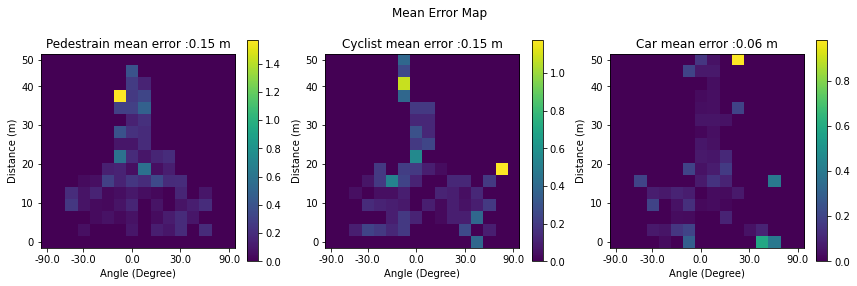

In [13]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
title = ['Pedestrain','Cyclist', 'Car']
ra_size =[16,16]
plt.suptitle('Mean Error Map')
fig.tight_layout()
max =0
for label in range(3):
    gt_r = [int(idx ) for idx in cls[f"{label}"]['asc']['gt_r']]
    gt_a = [int(idx ) for idx in cls[f"{label}"]['asc']['gt_a']]
    pd_r = [int(idx ) for idx in cls[f"{label}"]['asc']['pd_r']]
    pd_a = [int(idx ) for idx in cls[f"{label}"]['asc']['gt_a']]
    glb_dist =[]

    error = np.zeros((16,16))
    for i in range(16):
        for j in range(16):
            idx_bin = []
            dist =[]
            for cnt,gt_ir in enumerate(gt_r):
                if gt_ir>=i*16 and gt_ir<(i+1)*16 and gt_a[cnt]>=j*16 and gt_a[cnt]<(j+1)*16:
                    idx_bin=np.append(idx_bin,cnt)
            idx_bin = [int(idx) for idx in idx_bin]
            if len(idx_bin)!=0:
                for idx in idx_bin:
                    x_g,y_g = pol2cord(gt_r[idx], gt_a[idx])
                    x_p,y_p = pol2cord(pd_r[idx],pd_a[idx])
                    dist = np.append(dist,distance(x_g,y_g,x_p,y_p))
                    glb_dist = np.append(glb_dist,distance(x_g,y_g,x_p,y_p))
                    max = np.max((max,np.mean(dist)))
                error[i,j] = np.mean(dist)

    im = ax[label].imshow(error)
    ax[label].set_xticks([0, ra_size[1]*1/4-1,ra_size[1]*2/4-1,ra_size[1]*3/4-1,ra_size[1]-1])
    ax[label].set_yticks([0,ra_size[1]*1/5-1,ra_size[1]*2/5-1,ra_size[1]*3/5-1, ra_size[1]*4/5-1,ra_size[1]-1])
    ax[label].set_yticklabels([50, 40, 30, 20, 10, 0])
    ax[label].set_xticklabels(np.round(np.rad2deg(np.arcsin(np.linspace(-1,1,5))),1))
    ax[label].set_ylabel('Distance (m)')
    ax[label].set_xlabel('Angle (Degree)')
    mean = "{:.2f}".format(np.mean(glb_dist))
    ax[label].title.set_text(title[label] + f" mean error :{mean} m")
    fig.colorbar(im,ax=ax[label])
#plt.savefig(os.path.join(destination,'distmse.jpg'),dpi=1200)

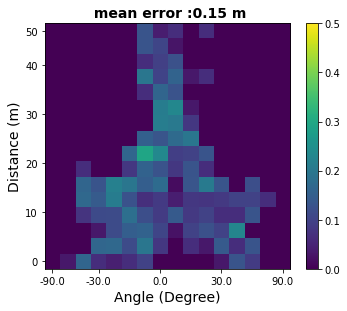

In [18]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
title = ['Pedestrain','Cyclist', 'Car']
ra_size =[16,16]
#plt.suptitle('Mean Error Map')
fig.tight_layout()
max =0
mean_d = 0
error_f = np.zeros((3,16,16))
for label in range(3):
    gt_r = [int(idx ) for idx in cls[f"{label}"]['asc']['gt_r']]
    gt_a = [int(idx ) for idx in cls[f"{label}"]['asc']['gt_a']]
    pd_r = [int(idx ) for idx in cls[f"{label}"]['asc']['pd_r']]
    pd_a = [int(idx ) for idx in cls[f"{label}"]['asc']['gt_a']]
    glb_dist =[]

    error = np.zeros((16,16))
    for i in range(16):
        for j in range(16):
            idx_bin = []
            dist =[]
            for cnt,gt_ir in enumerate(gt_r):
                if gt_ir>=i*16 and gt_ir<(i+1)*16 and gt_a[cnt]>=j*16 and gt_a[cnt]<(j+1)*16:
                    idx_bin=np.append(idx_bin,cnt)
            idx_bin = [int(idx) for idx in idx_bin]
            if len(idx_bin)!=0:
                for idx in idx_bin:
                    x_g,y_g = pol2cord(gt_r[idx], gt_a[idx])
                    x_p,y_p = pol2cord(pd_r[idx],pd_a[idx])
                    dist = np.append(dist,distance(x_g,y_g,x_p,y_p))
                    glb_dist = np.append(glb_dist,distance(x_g,y_g,x_p,y_p))
                    max = np.max((max,np.mean(dist)))
                error[i,j] = np.mean(dist)
    error_f[label,::]=error
    mean_d += np.mean(glb_dist)
im = ax.imshow(np.mean(error_f,axis=0),vmin=0,vmax=0.5)
ax.set_xticks([0, ra_size[1]*1/4-1,ra_size[1]*2/4-1,ra_size[1]*3/4-1,ra_size[1]-1])
ax.set_yticks([0,ra_size[1]*1/5-1,ra_size[1]*2/5-1,ra_size[1]*3/5-1, ra_size[1]*4/5-1,ra_size[1]-1])
ax.set_yticklabels([50, 40, 30, 20, 10, 0])
ax.set_xticklabels(np.round(np.rad2deg(np.arcsin(np.linspace(-1,1,5))),1))
ax.set_ylabel('Distance (m)',fontsize=14)
ax.set_xlabel('Angle (Degree)',fontsize=14)
mean = "{:.2f}".format(mean_d/3)

ax.set_title(f" mean error :{mean} m",size=14,fontweight ='bold')
fig.colorbar(im,ax=ax)
plt.savefig(os.path.join(destination,'distmse_bi.png'),dpi=1200)

In [7]:
mean

'0.10'

In [10]:
destination = r'G:\EFS-GX6\4130_Arbeitsgruppen\4137_KHO_Performance\Studentische_Themen\RaviKothari\thesis\images'

In [11]:
plt.savefig(os.path.join(destination,'distmse.pnj'),dpi=1200)

<Figure size 432x288 with 0 Axes>